# Board Game Concierge: Answering Questions for Complex Board Games  
## Fine-tuning DistilBERT Question-Answering on an unsupervised, small-domain corpus.  

In the realm of complex board games, rules questions abound. A tool that simply answers a player's rules questions would be helpful. An NLP solution applied to this problem may be able to take advantage of a special circumstance of this realm: Questions themselves will only be asked of the exact text corpus that the fine-tuned model would be trained on. Thus, overfitting on the training corpus is good.

 

## Overview
We offer a raw demonstrate of the Board Game Concierge concept in this notebook with the 25k+ word-count rules of the board game High Frontier 4 All (base game). This notebook uses spaCy to isolate key game terms (keywords) and create a glossary, and then fine-tune the vanilla DistilBERT QA model to create a question answering facility, all to assist learning these rules.

To this end, a major component of data cleaning is clearing out the rich and fascinating flavor text (of which there are about 5,000 words) which effectively contains no game rules, so that the model only trains on rules.  

Raw rules files created by exporting text from pdf versions of game rules with (the rather ancient) Adobe Acrobat 9 Pro. Resulting text files apparently contained some esoteric encoding, so were then encoded as pure utf8.

In [1]:
# Need huggingface's transformers and datasets
!pip install transformers datasets

In [2]:
import os
import pandas as pd
from google.colab import files
import re
import spacy
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForMaskedLM, AutoModelForQuestionAnswering
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling, default_data_collator
from transformers import pipeline
from datasets import load_dataset, load_metric

##Preprocessing Game Rules Text

The first step to implementing the concierge for a new board game is preprocessing the rules text. The exact steps vary greatly depending on the starting qualities of the individual rules and the desired ending quality (i.e., effectiveness for training). Generally, we want to remove flavor text and build long passages (less than 512 tokens) of cohesive rules text as training examples.  

In this notebook, we process the game rules for High Frontier 4 All  

> High Frontier 4 All Core Rules   
Copyright &copy; 2020 Ion Game Design & Sierra Madre Games  
Lead Designer: Phil Eklund

I intended to clean all the data in python, but threw in the towel and performed the following big & easy tasks in Notepad++...  
* Removed title and document opening text
* Removed end credits
* Removed hyphens from words broken at new lines.  
[*Note:* I could not figure out in python how to isolate broken-work hyphens from dozen other dashes.]
* Replaced curly quotes (opening and closing) with straight ones.
* Removed a handful of sidebar titles with no further text
* Fixed multiple occurances of this mispelling: IRSU --> ISRU
* Removed several new lines as noticed that served no purpose and followed no pattern (artifacts of pdf text export?)
  * Removed entire footnotes #3, #17, #42, #45, #47 because they contained arbitrary new lines
* Removed the "Scale" entry from glossary (quite lengthy and all flavor... but fascinating).
* Made certain each glossary entry began with the entry name and period.
* Encoded doc as UTF-8.  

The following is performed in python (below)...  
* Remove footnotes (all flavor text).
* Remove footnote citations.
* Replace tabs with spaces
* Remove excess spaces
* Remove excess new lines
* Remove arbitrary new lines (from pdf text export?)
* Merge headers (i.e. paragraphs with no verbs... as detected by spaCy) into the sentences that follow them
* Remove extraneous inter-document references







In [76]:
# Start working on the core rules

with open(r'HF4CoreRules_utf8.txt', 'r') as f:
  f = f.read()

f[:1000]

'A. Introduction\nThese Core rules (including the glossary at the end) comprise the base game, and are expanded by the tutorials, variants, and modules.\nA1. Core Overview \nPlayers, representing the spacefaring factions of Earth, bid for patents (space technology cards) and boost them into Low Earth Orbit (LEO) to be assembled into Rockets and their Cargos. Water in LEO is used both as commodity currency and as rocket propellant, and each water container there is called one Aqua. Once loaded with Fuel Tanks (FTs) of water, Rockets fly to promising industrial and science Sites (planets, asteroids, etc.). If prospecting succeeds, a Claim is made. A Claim can be upgraded to a Factory to produce useful new equipment. By extracting water from a Site, FTs are produced both for water propellant and as money ("Aqua") if shipped back to LEO.11 WATER, THE KEY TO THE SOLAR SYSTEM. No place in space has resource value without a local supply of water, primarily for rocket propellant and "exofuels"

In [6]:
# Isolate footnotes using regular expressions in order to remove them later

p_footnote = re.compile(r"""
    ([0-9]+)\1                   # pair of back-to-back footnote indices (i.e., doubled up combination of digits)
    \s?                          # optional space before footnote title
    [A-Z]{2,}[-|,|.|\b]?\s?      # first word of title, i.e., a 2+-letter, all-cap word followed by an optional separator plus an optional space
    .+                           # text up to new line
""", re.VERBOSE)
footnotes = p_footnote.finditer(f)

for note in footnotes:
  print(note.group())
  print(note.span())

# We see footnotes numbered 1-55 (i.e., less #42), looks good!
# Note: A couple footnotes are followed by a little bit of legit rules text (which is removed) before the new line is reached, which is lost.

11 WATER, THE KEY TO THE SOLAR SYSTEM. No place in space has resource value without a local supply of water, primarily for rocket propellant and "exofuels", but also for chemical and mineralogical processing, dust control, crops, and life support. Water is a storable and convenient source of hydrogen, the superior propellant for thermodynamic rockets. Water is a natural shield against energetic protons, kilo for kilo better than regolith or even metals. Finally, without recycling, each man-year requires 10 tonnes of water. (Although it is worth noting that human metabolisms convert carbohydrates plus oxygen into carbon dioxide and water, thus we are stoichiometrically net producers rather than consumers of water.) 
(841, 1565)
22 WATER AVAILABILITY is greatest on worlds with icy cores, where simply injecting steam into a wellhole produces water. On drier worlds, where water only occurs as tiny ice crystals or hydrated silicates, the regolith would need to be crushed, sealed in a vessel

In [7]:
# Delete selected footnotes

print('BEFORE REMOVING FOOTNOTES:\n', f[800:2000], '\n\n')
f_defoot = p_footnote.sub(' ', f)
print('AFTER REMOVING FOOTNOTES:\n', f_defoot[800:2000])

# Now we see a footnote citation ("- Glenn Macpherson,...") that would be easy enough to isolate and remove with RE

BEFORE REMOVING FOOTNOTES:
 as money ("Aqua") if shipped back to LEO.11 WATER, THE KEY TO THE SOLAR SYSTEM. No place in space has resource value without a local supply of water, primarily for rocket propellant and "exofuels", but also for chemical and mineralogical processing, dust control, crops, and life support. Water is a storable and convenient source of hydrogen, the superior propellant for thermodynamic rockets. Water is a natural shield against energetic protons, kilo for kilo better than regolith or even metals. Finally, without recycling, each man-year requires 10 tonnes of water. (Although it is worth noting that human metabolisms convert carbohydrates plus oxygen into carbon dioxide and water, thus we are stoichiometrically net producers rather than consumers of water.) 
— Glenn MacPherson, Oxygen in the Solar System, Lunar & Planetary Institute, 2008. 
 
a.	Core Game Victory. At the end of 48 years (48 Turns per player), the winner is the player with the highest victory po

In [8]:
# Isolate footnote citations

p_citation = re.compile(r"""
    —        # big dash [I think n- and m-dashes both converted to this thing during upload]
    \s?      # optional space
    .+?      # text (non-greedily) up to next required element (comma)
    ,        # comma
    .+       # text up to new line
""", re.VERBOSE)

citations = p_citation.finditer(f_defoot)

for cite in citations:
  print(cite.group())
  print(cite.span())

# 5 citations found

— Glenn MacPherson, Oxygen in the Solar System, Lunar & Planetary Institute, 2008. 
(843, 926)
—Namrata Goswami, China’s grand strategy in outer space: to establish compelling standards of behavior, 2019.
(35099, 35208)
—Ruslan Belikov, NASA Ames, personal communication, 2020.
(43632, 43689)
—Hepp, Landis, Kubiak, Carbon Dioxide Utilization on Mars, 1993.
(52933, 52997)
—JED Cline, The Mooncable: A Profitable Space Transportation System, 1972.
(93992, 94066)


In [9]:
# Delete selected footnote citations

print('BEFORE REMOVING CITATIONS:\n', f_defoot[800:1000], '\n\n')
f_defoot = p_citation.sub(' ', f_defoot)
print('AFTER REMOVING CITATIONS:\n', f_defoot[800:1000])

BEFORE REMOVING CITATIONS:
 as money ("Aqua") if shipped back to LEO. 
— Glenn MacPherson, Oxygen in the Solar System, Lunar & Planetary Institute, 2008. 
 
a.	Core Game Victory. At the end of 48 years (48 Turns per player), the 


AFTER REMOVING CITATIONS:
 as money ("Aqua") if shipped back to LEO. 
 
 
a.	Core Game Victory. At the end of 48 years (48 Turns per player), the winner is the player with the highest victory point (VP) total. 
b.	Sunspot Cycle


In [10]:
# Replace tabs with spaces
f_defoot = f_defoot.replace('\t', ' ')

# Remove excess spaces
f_defoot = re.sub(' {2,}', ' ', f_defoot)

# Remove excess new lines
f_defoot = re.sub('\n{2,}', '\n', f_defoot)

# Replace space + new line + space with space (fixing artifact of export from pdf)
f_defoot = re.sub(' \n ', ' ', f_defoot)

In [11]:
"""
This cell is a little tool for manually pasting in a string, and returning how spaCy identifies the parts of speech therein
"""

pos = spacy.load('en_core_web_sm')
doc = pos('B5. Solar System Charts')
for token in doc:
  print(token.text, token.pos_, token.tag_)

B5 PROPN NNP
. PUNCT .
Solar ADJ JJ
System NOUN NN
Charts VERB VBZ


In [12]:
"""
Merge Headers
Append each header (i.e., each paragraph with no verb) to the sentence in front of it.
Use the spaCy nlp model 'en_core_web_sm' to determine if a given paragraph has a verb or not.
"""

def contains_verb(string, spacy_model):
  tokens = spacy_model(string)
  for t in tokens:
    if (t.pos_, t.tag_) in [
                             ('AUX', 'VBD'),
                             ('AUX', 'VBP'),
                             ('AUX', 'VBZ'),
                             ('AUX', 'VB'),
                             ('VERB', 'VBP'),
                             ('VERB', 'VBD'),
                             ('VERB', 'VBZ'),
                             ('VERB', 'VB'),
                           ]:
      return True
  return False

spacy_model = spacy.load('en_core_web_sm')
paragraphs = f_defoot.split('\n')

f_headsMerged = []       # This is the corpus updated with merged headers
headers = []             # This list is just the headers, provides a quick look at what is being identified
header = ''
for p in paragraphs:
  if contains_verb(p, spacy_model):
    f_headsMerged.append(header + p)
    header = ''
  else:
    p = p.strip('.: ') + '. '    # clean up headers (stnadardize with trailing period and space)
    headers.append(p)
    header = header + p     # Note: Adjacent header paragraphs are concantenated into a single header

print('Original paragraph count:', len(paragraphs), '\nAfter merging headers:', len(f_headsMerged), '\n')
for h in headers[:20]:
  print(h)

# Investigating the entire headers list reveals a half dozen or so paragraphs with verbs that spaCy incorrectly identified as having no verbs.
# The purpose of merging headers is to simply partner the great majority of disparate headers with an associated sentence to facilitate training.
# A few paragraph pairs grouped into a single paragraph is not a problem (particularly how the one with no identified verbs will likely be short).

Original paragraph count: 1060 
After merging headers: 809 

A. Introduction. 
A1. Core Overview. 
. 
A2. Metarules. 
EXAMPLE [A2a]. 
A3. Introductory Games. 
B. Components & Anatomies. 
B1. Component List. 
B2. Patent Cards. 
( J3a). 
j. Rad-Hardness. Resistance to solar flares ( K2d), and Radiation Belts ( H10). 
B3. Glory & Heroism Chits. 
B4. Playmats. 
B6. Crew Cards. 
b. Faction Ideology. (Module 0). Used for placing delegates (O2c). 
B7. Solar System Map. 
B8. Tokens. 
C. Core Setup. 
C1. Seniority Disk Placement. 
C2. Assign Factions & Crew. 


In [14]:
"""
We can see how headers are prepended to paragraphs.
Of course, not ever paragraph with a verb is preceded by a header.
"""

f_headsMerged[200:240]

# Looking at the first 40 lines of f_headsMerged, we can see an error from spaCy POS where a noun is incorrectly
# identified as a verb (Charts in 'B5. Solar System Charts'), thus an actual header is not merged with the parapraph following it.
# Occasional errors like this are probably not worth fixing.

['EXAMPLE [H3b]. A Rocket with a Dry Mass of 7 and a Wet Mass of 8½ is transport class (Wet Mass thrust modifier of -1). If its thruster has a base thrust of 1, its net thrust is 1 - 1 = 0. It can only coast with zero thrust, so it jettisons one step of Fuel to bring it to scout class (Wet Mass 8). This class has a Wet Mass modifier of 0, allowing it to move. ',
 'c. Solar-Power Modifier. If the thruster or any card in its support chain has the solar-powered icon ( J5b), increase or decrease the net thrust depending on which Heliocentric Zone it’s in (-5 to +2, as indicated on the map). • Multiple Solar Modifiers. This modifier only applies once regardless of the amount of solar icons in the support chain. • Neptune Solar. Solar-Powered Cards are non-operational in the Neptune J Heliocentric Zone (B7g), unless they get a push (next bullet). If so, thrust has a -6 modifier.',
 'EXAMPLE [H3c]. Your Rocket has a mass driver (4•3) activated, which is powered by a solar-powered generator (f

(array([16., 37., 64., 97., 78., 67., 75., 56., 61., 41., 38., 36., 29.,
        25., 13., 20.,  8.,  8.,  7.,  5.,  3.,  7.,  6.,  4.,  0.,  1.,
         2.,  2.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([  13.  ,   38.08,   63.16,   88.24,  113.32,  138.4 ,  163.48,
         188.56,  213.64,  238.72,  263.8 ,  288.88,  313.96,  339.04,
         364.12,  389.2 ,  414.28,  439.36,  464.44,  489.52,  514.6 ,
         539.68,  564.76,  589.84,  614.92,  640.  ,  665.08,  690.16,
         715.24,  740.32,  765.4 ,  790.48,  815.56,  840.64,  865.72,
         890.8 ,  915.88,  940.96,  966.04,  991.12, 1016.2 , 1041.28,
        1066.36, 1091.44, 1116.52, 1141.6 , 1166.68, 1191.76, 1216.84,
        1241.92, 1267.  ]),
 <a list of 50 Patch objects>)

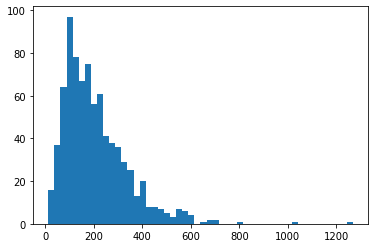

In [14]:
"""
Sanity check, look at distribution of sentence sizes.
"""

lengths = [len(p) for p in f_headsMerged]
plt.hist(lengths, bins=50)

# Looks like majority of paragraphs in f_headsMerged have between 60 and 350 characters with max at 1300. Should all tokenize to less than 512 word-part tokens.

In [15]:
"""
Tokenize our rules paragraphs.
We will work with DistilBERT models all using the same tokenizer checkpoint 'distilbert-base-uncased'.
"""

tokenizer_checkpoint = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(tokenizer_checkpoint, use_fast=True)
tokenized_data = tokenizer(f_headsMerged)
len(tokenized_data['input_ids'])

# Sanity check, there are 809 lists of input_ids, one per paragraph, this checks out.

809

## Fine-Tuning DistilBERT Encoders

In [19]:
# Vanilla DistilBERT for masked language modeling is our starting point for fine-tuning.

untuned_maskedLM = AutoModelForMaskedLM.from_pretrained(tokenizer_checkpoint)

In [20]:
"""
ESTABLISH BENCHMARK
Run a set of highly technical game rules sentences with a masked token through vanilla DistilBERT MaskedLM before fine-tuning. 
Note the top 5 suggestions and confidence scores; we will run the same sentences through after fine-tuning the model on the game rules.
"""

# answer1 = 'spacecraft'
sentence1 = 'The dry mass chit is a token on the fuel strip indicating the mass of a [MASK], not counting its fuel.'

# answer2 = 'heavy'
sentence2 = 'A radiator card played in its [MASK] Orientation rotates to its light Orientation instead of being involuntarily decommissioned upon failing Glitch Rolls, Hazard Rolls, or Belt Rolls.'

# answer3 = 'triangle'
sentence3 = 'Performing a Burn expends a number of fuel steps (not tanks) equal to the fuel consumption of the activated thrust [MASK].'

untuned_maskedLM_pipe = pipeline('fill-mask', model=untuned_maskedLM, tokenizer=tokenizer)
print(untuned_maskedLM_pipe(sentence1))
print(untuned_maskedLM_pipe(sentence2))
print(untuned_maskedLM_pipe(sentence3))

# We observe:
# suggested answer1's: 'vehicle' (48%), 'spacecraft' [CORRECT ANSWER] (6%), 'tank' (5%), 'fuel' (4%), 'rocket' (3%) ... got the right answer, but with 6% confidence
# suggested answer2's: 'light' (5%), 'dark' (5%), 'reverse' (3%), 'normal' (3%), 'vertical' (2%)
# suggested answer3's: 'thrusters' (14%), 'thruster' (12%), 'thrust pump' (8%), 'thrust engine' (6%), 'thrust tank' (4%)

[{'sequence': 'the dry mass chit is a token on the fuel strip indicating the mass of a vehicle, not counting its fuel.', 'score': 0.4811486303806305, 'token': 4316, 'token_str': 'vehicle'}, {'sequence': 'the dry mass chit is a token on the fuel strip indicating the mass of a spacecraft, not counting its fuel.', 'score': 0.06393516063690186, 'token': 12076, 'token_str': 'spacecraft'}, {'sequence': 'the dry mass chit is a token on the fuel strip indicating the mass of a tank, not counting its fuel.', 'score': 0.05208580568432808, 'token': 4951, 'token_str': 'tank'}, {'sequence': 'the dry mass chit is a token on the fuel strip indicating the mass of a fuel, not counting its fuel.', 'score': 0.035906195640563965, 'token': 4762, 'token_str': 'fuel'}, {'sequence': 'the dry mass chit is a token on the fuel strip indicating the mass of a rocket, not counting its fuel.', 'score': 0.03025912493467331, 'token': 7596, 'token_str': 'rocket'}]
[{'sequence': 'a radiator card played in its light orien

In [18]:
"""
SET UP MODEL
The idea is to fine tune the off-the-shelf DistilBERT masked language model
on our game rules (tokenized_data) as this does not require us to label our examples.
We create the dataCollator and Trainer and use default learning rate (5e-5) for now.
Training set is small, seems to converge after 50 or so epochs.
"""

collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)

training_args = TrainingArguments(
    output_dir = 'finetuned-output',
    overwrite_output_dir = True,
    evaluation_strategy = 'no',
    num_train_epochs = 50,
    per_device_train_batch_size = 16,
    save_total_limit = 1
)

trainer = Trainer(
    model = untuned_maskedLM,
    args = training_args,
    train_dataset = tokenized_data['input_ids'],
    data_collator = collator
)

In [68]:
"""
TRAIN MODEL
You can either train the model yourself (took me about 8 minutes on the Colab Pro GPU runtime)
or load my trained model by running this cell as is (i.e., with !wget line uncommented).
"""

# trainer.train()
# trainer.save_model('mlm_tuned')

--2021-11-04 20:35:40--  https://drive.google.com/file/d/1FqaVKtJwwv4ArVe92OQCE_KShf9EeKUu/view?usp=sharing
Resolving drive.google.com (drive.google.com)... 64.233.170.102, 64.233.170.138, 64.233.170.100, ...
Connecting to drive.google.com (drive.google.com)|64.233.170.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘HF4CoreRules_utf8.txt’

HF4CoreRules_utf8.t     [ <=>                ]  65.50K  --.-KB/s    in 0.004s  

2021-11-04 20:35:40 (16.7 MB/s) - ‘HF4CoreRules_utf8.txt’ saved [67069]



In [16]:
"""
Make a model with fine-tuned weights to compare it's capabilities with the benchmark earlier
"""
tuned_model = AutoModelForMaskedLM.from_pretrained('mlm_tuned')

In [21]:
"""
Compare to vanilla benchmarks, run the sample sentence through fine-tuned model.
Should ackowledge that our goal here is to grossly overfit on our game rules
because the actual application of this model will be to answer question directly on 
passages from those rules.
"""

tuned_maskedLM = pipeline('fill-mask', model=tuned_model, tokenizer=tokenizer)
print(tuned_maskedLM(sentence1))
print(tuned_maskedLM(sentence2))
print(tuned_maskedLM(sentence3))

# We observe significant improvement with fine-tuning:
# suggested answer1's: 'spacecraft' [CORRECT ANSWER] (99+%) ... remaining suggestions each have less than 1% confidence
# suggested answer2's: 'heavy' [CORRECT ANSWER] (99+%) ... remaining suggestions each have less than 1% confidence
# suggested answer3's: 'thruster' (85%), 'triangle' [CORRECT ANSWER] (14%) ... remaining suggestions each have less than 1% confidence

[{'sequence': 'the dry mass chit is a token on the fuel strip indicating the mass of a spacecraft, not counting its fuel.', 'score': 0.9976863861083984, 'token': 12076, 'token_str': 'spacecraft'}, {'sequence': 'the dry mass chit is a token on the fuel strip indicating the mass of a rocket, not counting its fuel.', 'score': 0.0007102998206391931, 'token': 7596, 'token_str': 'rocket'}, {'sequence': 'the dry mass chit is a token on the fuel strip indicating the mass of a card, not counting its fuel.', 'score': 0.00037066664663143456, 'token': 4003, 'token_str': 'card'}, {'sequence': 'the dry mass chit is a token on the fuel strip indicating the mass of a vehicle, not counting its fuel.', 'score': 0.00033013144275173545, 'token': 4316, 'token_str': 'vehicle'}, {'sequence': 'the dry mass chit is a token on the fuel strip indicating the mass of a stack, not counting its fuel.', 'score': 0.0002827711869031191, 'token': 9991, 'token_str': 'stack'}]
[{'sequence': 'a radiator card played in its 

## Fine-tuning a DistilBERT QA Model

In [22]:
"""
Now let's replace the head on our fine-tuned maskedLM model ('distilbert_tuned') with a questioning-answering head.
The idea is to then fine tune the question-answering head (initialized with random values) and the top few encoders
on a general corpus of question-answering examples (SQaUD v1). Hopefully some knowledge of our game rules will be retained.
Truth be told, I initially tried freezing all the encoder blocks and only tuning the 768 parameters of the QA head... disasterous.
"""

qa_model = AutoModelForQuestionAnswering.from_pretrained('mlm_tuned')

# freeze the parameters of our fine-tuned encoder blocks except for last 48 layers (i.e., top 3 encoder blocks... out  of 6)
# Note: the question-answering head is also unfrozen
for p in [param for param in qa_model.base_model.parameters()][:-48]:
  p.requires_grad = False

Some weights of the model checkpoint at mlm_tuned were not used when initializing DistilBertForQuestionAnswering: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at mlm_tuned and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to b

### Preprocessing SQaUD v1

In [ ]:
datasets = load_dataset('squad')
datasets

# Observe 87k+ labeled training examples and 10k+ validation... somebody was busy

Downloading:   0%|          | 0.00/1.97k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/8.12M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.05M [00:00<?, ?B/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset squad downloaded and prepared to /root/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})

In [ ]:
"""
We're just going to drop examples with more words than, say, 25% of the model's input token limit
to avoid having the correct answer in long context passages truncated away by the tokenizer
and (truthfully) to avoid splitting the contexts up into different examples. We actually don't need
a ton of training examples to fine tune the QA head as we'll quickly loose fidelity of our game rules domain.
"""

# published maximum length of tokens of examples fed into distilbert-base-uncased
max_length = 512

print("# of trainiing examples total:", len(datasets['train'])) 

datasets['train'] = datasets['train'].filter(lambda x: len((x['question'] + x['context']).split()) < max_length*0.25)
datasets['validation'] = datasets['validation'].filter(lambda x: len((x['question'] + x['context']).split()) < max_length*0.25)

print('# of training examples with fewer words than 1/4 the tokenizer token limit:', len(datasets['train']))

# We still have 50k+ examples, plenty!

# of trainiing examples total: 87599


  0%|          | 0/88 [00:00<?, ?ba/s]

  0%|          | 0/11 [00:00<?, ?ba/s]

# of training examples with fewer words than 1/4 the tokenizer token limit: 50545


In [ ]:
# Set idx to an example's index to observe its data structure
# Of course, the 'answer' to the 'question' must be a single continuous string of characters from the 'context'

idx = 1
datasets['train'][idx]

{'answers': {'answer_start': [145], 'text': ['Moreau Seminary']},
 'context': 'The university is the major seat of the Congregation of Holy Cross (albeit not its official headquarters, which are in Rome). Its main seminary, Moreau Seminary, is located on the campus across St. Joseph lake from the Main Building. Old College, the oldest building on campus and located near the shore of St. Mary lake, houses undergraduate seminarians. Retired priests and brothers reside in Fatima House (a former retreat center), Holy Cross House, as well as Columba Hall near the Grotto. The university through the Moreau Seminary has ties to theologian Frederick Buechner. While not Catholic, Buechner has praised writers from Notre Dame and Moreau Seminary created a Buechner Prize for Preaching.',
 'id': '5733bed24776f41900661189',
 'question': 'What is the primary seminary of the Congregation of the Holy Cross?',
 'title': 'University_of_Notre_Dame'}

In [ ]:
# This function tokenizes our SQuAD examples and identifies the starting and ending tokens of answers.

def prepare_train_features(examples):
    # Remove leading white spaces in SQuAD questions
    examples['question'] = [q.lstrip() for q in examples['question']]

    tokenized_examples = tokenizer(
        examples['question'],
        examples['context'],
        return_offsets_mapping = True,
        padding = 'max_length'
    )

    offset_mapping = tokenized_examples.pop('offset_mapping')

    tokenized_examples['start_positions'] = []
    tokenized_examples['end_positions'] = []

    for i, offsets in enumerate(offset_mapping):
      input_ids = tokenized_examples['input_ids'][i]
      sequence_ids = tokenized_examples.sequence_ids(i)
      answer = examples['answers'][i]

      start_char = answer['answer_start'][0]
      end_char = start_char + len(answer['text'][0])

      # Use sequence_ids() to identify the context portion (as opposed to the answer portion)
      # of the example's input string. The context corresponds to 1's in the list from sequence_ids().
      # Initially, token_start_index is set to the beginning of the context, token_end_index to its end.
      token_start_index = 0
      while sequence_ids[token_start_index] != 1:
        token_start_index += 1
      
      token_end_index = len(input_ids) - 1
      while sequence_ids[token_end_index] != 1:
        token_end_index -= 1

      # With the context identified, find the start and end tokens of the answer from therein.
      while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
        token_start_index += 1
      tokenized_examples['start_positions'].append(token_start_index - 1)
      while offsets[token_end_index][1] >= end_char:
        token_end_index -= 1 
      tokenized_examples['end_positions'].append(token_end_index + 1)

    return tokenized_examples

In [ ]:
tokenized_datasets = datasets.map(prepare_train_features, batched=True, remove_columns=datasets['train'].column_names)

  0%|          | 0/51 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

In [ ]:
# Set idx to an example's index to observe how it returns from prepare_train_features

idx = 1
example = tokenized_datasets['train'][idx]
start = example['start_positions']
end = example['end_positions']
print('context:', datasets['train']['context'][idx])
print('question:', datasets['train']['question'][idx])
print('answer label:', datasets['train']['answers'][idx]['text'][0])
print('processed answer decoded:', tokenizer.decode(example['input_ids'][start : end+1]))
print('processed answer token by token:', [tokenizer.decode(t) for t in example['input_ids'][start : end+1]])
print('first token index:', start)
print('last token index:', end)

context: The university is the major seat of the Congregation of Holy Cross (albeit not its official headquarters, which are in Rome). Its main seminary, Moreau Seminary, is located on the campus across St. Joseph lake from the Main Building. Old College, the oldest building on campus and located near the shore of St. Mary lake, houses undergraduate seminarians. Retired priests and brothers reside in Fatima House (a former retreat center), Holy Cross House, as well as Columba Hall near the Grotto. The university through the Moreau Seminary has ties to theologian Frederick Buechner. While not Catholic, Buechner has praised writers from Notre Dame and Moreau Seminary created a Buechner Prize for Preaching.
question: What is the primary seminary of the Congregation of the Holy Cross?
answer label: Moreau Seminary
processed answer decoded: moreau seminary
processed answer token by token: ['more', '##au', 'seminary']
first token index: 44
last token index: 46


### Training on SQuAD

In [ ]:
args = TrainingArguments(
    'qa_domain_adapted',
    evaluation_strategy = 'steps',
    learning_rate = 2e-5,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 16,
    num_train_epochs = 9,
    report_to = 'all'
)

trainer = Trainer(
    qa_model,
    args,
    train_dataset = tokenized_datasets['train'],
    eval_dataset = tokenized_datasets['validation'],
    data_collator = default_data_collator,
    tokenizer = tokenizer
)

using `logging_steps` to initialize `eval_steps` to 500
PyTorch: setting up devices


In [23]:
"""
TRAIN MODEL
You can either train the model yourself (took me about 3 hours on the Colab Pro GPU runtime)
or load my trained model by running this cell as is (i.e., with !wget line uncommented).
We have learned that 'qa_domain_adapted/checkpoint-24000' is the optimal checkpoint.
"""
#!wget...

!cp -r drive/MyDrive/highfrontier_rules/qa_domain_adapted/checkpoint-24000/ checkpoint-24000

# trainer.train()
# trainer.save_model('qa_tuned')

In [78]:
# 'qa_domain_adapted/checkpoint-24000' is the optimal checkpoint

qa_untuned_pipe = pipeline('question-answering', model='distilbert-base-uncased-distilled-squad', tokenizer=tokenizer)
qa_tuned_pipe = pipeline('question-answering', model='checkpoint-24000', tokenizer=tokenizer)

ValueError: ignored

In [24]:
"""
Create questions to run through the off-the-shelf distilbert QA and then through our tuned QA
"""
# We're looking for 'fuel grade' for an answer.
question1 = 'What does the Thrust Triangle color indicate?'
target1 = 'fuel grade'
passage1 = 'd. Thrust Triangle. Cards with a thrust triangle (H2) are capable of moving Stacks. The number on a thrust triangle’s left side is its base thrust and the number on its right side is its fuel consumption. The color of the triangle indicates its fuel grade (F4b). If it has a flame icon at its apex, it can afterburn (H3a). If instead of a dot icon, it has a push icon in its lower center, it is pushable (H3d).'

# Answer is 'blue'.
question2 = 'What color is the sky?'
target2 = 'blue'
passage2 = 'The sky is blue.'

# Answer is 'gold'.
question3 = 'What color of chit does an isotope thruster use?'
target3 = 'gold'
passage3 = 'c. Thruster Fuel Compatibility. A Spacecraft may be fueled with any type of Fuel, but it cannot expend Fuel in a Burn or use an afterburner (H3a) if the color of the activated thrust triangle is of a higher grade than the color of the Wet Mass Chit. • Assuming a Spacecraft must expend Fuel, a dirt thruster can be activated with any color Wet Mass Chit, a Water Thruster can be activated with a blue or gold Wet Mass Chit, and an Isotope Thruster can only activate with a gold Wet Mass Chit.'

# Answer is '-6'. This one seems quite difficult.
question4a = 'What thrust modifier do cards in the neptune zone receive if they get a push?'
question4b = 'What size is the thrust modifier cards in the neptune zone receive if they get a push?'
target4 = '-6'
passage4 = 'c. Solar-Power Modifier. If the thruster or any card in its support chain has the solar-powered icon ( J5b), increase or decrease the net thrust depending on which Heliocentric Zone it’s in (-5 to +2, as indicated on the map). • Multiple Solar Modifiers. This modifier only applies once regardless of the amount of solar icons in the support chain. • Neptune Solar. Solar-Powered Cards are non-operational in the Neptune J Heliocentric Zone (B7g), unless they get a push (next bullet). If so, thrust has a -6 modifier.'

question5 = 'What type of fuel can a dirt thruster use?'
target5 = 'any type'
passage5 = ' f. Fuel Grade Requirement. Thrust triangles are color-coded with a fuel grade (F4b). The Fuel expended when a Burn is used must be the same grade of Fuel or better (e.g., a dirt thruster can use any type of Fuel whilst a water Rocket may only use water or isotope Fuel).'

In [42]:
"""
This function takes a question, an iterable of contexts through, and a question-answering pipeline.
The pipeline poses the question to each context, and returns the answer with the highest confidence score, 
along with that score and the context where that answer was found.
"""

def question_all(question, contexts, pipeline):
  top_score = 0.0
  best_answer = ''
  best_context = ''
  for context in contexts:
    answer = pipeline(question, context)
    if answer['score'] > top_score:
      top_score = answer['score']
      best_answer = answer['answer']
      best_context = context

  return best_answer, top_score, best_context

In [41]:
test_combos = [
               (question1, target1, passage1, qa_untuned_pipe, 'untuned'),
               (question1, target1, passage1, qa_tuned_pipe, 'tuned'),
               (question2, target2, passage2, qa_untuned_pipe, 'untuned'),
               (question2, target2, passage2, qa_tuned_pipe, 'tuned'),
               (question3, target3, passage3, qa_untuned_pipe, 'untuned'),
               (question3, target3, passage3, qa_tuned_pipe, 'tuned'),
               (question4a, target4, passage4, qa_untuned_pipe, 'untuned'),
               (question4a, target4, passage4, qa_tuned_pipe, 'tuned'),
               (question4b, target4, passage4, qa_untuned_pipe, 'untuned'),
               (question4b, target4, passage4, qa_tuned_pipe, 'tuned'),
               (question5, target5, passage5, qa_untuned_pipe, 'untuned'),
               (question5, target5, passage5, qa_tuned_pipe, 'tuned')
]

prev_question = ''
for question, target, context, pipeline, label in test_combos:
  answer, score, _ = question_all(question, [context], pipeline)
  if question != prev_question:
    print()
    print(f'{question}  CORRECT ANS: {target}')
    print(context)
    prev_question = question
  print(f'{label} answer: {answer}  --> {score:.2%}')


What does the Thrust Triangle color indicate?  CORRECT ANS: fuel grade
d. Thrust Triangle. Cards with a thrust triangle (H2) are capable of moving Stacks. The number on a thrust triangle’s left side is its base thrust and the number on its right side is its fuel consumption. The color of the triangle indicates its fuel grade (F4b). If it has a flame icon at its apex, it can afterburn (H3a). If instead of a dot icon, it has a push icon in its lower center, it is pushable (H3d).
untuned answer: fuel grade  --> 31.22%
tuned answer: fuel grade  --> 56.46%

What color is the sky?  CORRECT ANS: blue
The sky is blue.
untuned answer: blue  --> 96.17%
tuned answer: blue  --> 99.83%

What color of chit does an isotope thruster use?  CORRECT ANS: gold
c. Thruster Fuel Compatibility. A Spacecraft may be fueled with any type of Fuel, but it cannot expend Fuel in a Burn or use an afterburner (H3a) if the color of the activated thrust triangle is of a higher grade than the color of the Wet Mass Chit

### Crux of It
The performance of the question-answering DistilBERT model tuned on our game rules versus the off-the-shelf version is the fundamental issue here. Based on the handful of one-off comparisons above, we see that there is reason to be optimistic. Plenty of follow-up questions now arise...
- Why is the domain-adapted model more confident with the color of the sky? (question 2)
- Why the disparity between "What thrust modifer..." and "What size is the thrust modifier..."? (4th and 5th questions)
- Why is the domain-adpated model so abyssmal with a "what type of" question? (last question)

At the end of the day, I think it would be worth putting a UI together and putting it in front of players for further research. For now, the rest of this notebook details how a player question is processed.

## Identifying Keywords Using spaCy
We want to run a user's question by multiple relevant paragraphs from the game rules and return the answer with the most confidence. We don't want to run it by *all* the paragraphs because it would take too long and, more importantly, the quirky question-answering model would find some irrelevant paragraph arbitrarily to feel very confident about. We only want to look for answers in the paragrphs with the most similarity to the question, i.e., those that share the most keywords.

In [ ]:
"""
If you're curious, you can run a question through the entire rules corpus to see what "brilliant" answer our qa model returns.
"""

answer, score, context = question_all('What color is Mars?', f_headsMerged, qa_tuned_pipe)
print(answer)
print(score)
print(context)

# With "What color is Mars?", the off-the-shelf DistilBERT chooses 'red' correctly, but it does so from a passage that does not mention Mars.
# I think it already knew the answer and just needed a sentence that contained 'red' somewhere.
# Of course, our tuned qa model doesn't have a clue (though very confident!).

yellow
0.9988766312599182
f. Buggy Road is a route with a dashed yellow line. It is used during buggy prospecting, but can also be used to move Crew (H9a).


In [27]:
"""
Enter spaCy...
"""

spacy_model = spacy.load('en_core_web_sm')

In [28]:
"""
Need a function to tokenize each rules paragraph (plus remove stop words and non-alpha characters).
"""

def simple_tokens(paragraphs, spacy_model):
  paragraphs_tokenized = []
  for p in paragraphs:
    tokens = spacy_model(p)
    paragraphs_tokenized.append([t.text.lower() for t in tokens if not (t.is_stop or re.match(r'.*[\W\d]+', t.text))])
  return paragraphs_tokenized

test_paragraphs = [
             'I love new york. You hardly love it. yb5 [21]',
             'The dog and the cat had tea in heaven?',
             'The last cat haven between new york and heaven! New York?'
]

test_tokens = simple_tokens(test_paragraphs, spacy_model)
test_tokens

[['love', 'new', 'york', 'hardly', 'love'],
 ['dog', 'cat', 'tea', 'heaven'],
 ['cat', 'haven', 'new', 'york', 'heaven', 'new', 'york']]

In [29]:
"""
Need a function to map each word to a list of indices of rules paragraphs that contain that word
"""

def keyword_map(tokens_list):
  keyword_dict = {}
  for idx, tokens in enumerate(tokens_list):
    for t in tokens:
      if t in keyword_dict:
        keyword_dict[t].add(idx)
      else:
        keyword_dict[t] = set([idx])
  return keyword_dict

test_mapping = keyword_map(test_tokens)
test_mapping

{'cat': {1, 2},
 'dog': {1},
 'hardly': {0},
 'haven': {2},
 'heaven': {1, 2},
 'love': {0},
 'new': {0, 2},
 'tea': {1},
 'york': {0, 2}}

In [31]:
"""
Create the keyword map for our game rules
"""

rules_tokens = simple_tokens(f_headsMerged, spacy_model)
keyword_dict = keyword_map(rules_tokens)
print(f'# of keywords {len(keyword_dict)}')

# of keywords 2266


In [32]:
"""
Sanity check, keywords look appropriately captured in dictionary
"""

for k,v in [(k,v) for k,v in keyword_dict.items()][40:60]:
  print(f'{k}: {v}')

fuel: {1, 15, 17, 530, 531, 536, 537, 26, 538, 539, 38, 40, 46, 567, 568, 57, 586, 588, 589, 590, 92, 95, 96, 97, 98, 607, 609, 611, 104, 617, 107, 111, 113, 114, 115, 116, 119, 120, 123, 126, 128, 130, 131, 132, 133, 134, 135, 136, 139, 141, 142, 144, 146, 147, 658, 150, 151, 152, 662, 154, 157, 158, 159, 672, 694, 695, 696, 186, 187, 701, 192, 193, 195, 708, 709, 198, 199, 200, 710, 716, 206, 208, 721, 722, 211, 723, 724, 728, 218, 730, 220, 221, 222, 732, 224, 225, 738, 228, 741, 230, 743, 744, 233, 234, 235, 746, 237, 238, 747, 753, 765, 766, 767, 257, 769, 259, 261, 262, 788, 794, 303, 305, 310, 311, 312, 397, 401}
tanks: {1, 769, 160, 303, 304, 306, 310, 567, 447, 708, 722, 723, 218, 220, 96, 99, 621, 112, 115, 243, 766, 767}
fts: {1, 130, 134, 135, 520, 137, 776, 139, 140, 141, 145, 146, 148, 279, 152, 154, 541, 159, 672, 675, 681, 298, 299, 555, 173, 560, 305, 50, 439, 567, 187, 188, 706, 707, 709, 586, 587, 588, 714, 716, 80, 81, 82, 721, 86, 730, 92, 607, 609, 357, 615, 104, 

(array([1.671e+03, 2.150e+02, 1.070e+02, 6.700e+01, 4.300e+01, 3.000e+01,
        3.600e+01, 1.800e+01, 1.000e+01, 1.700e+01, 4.000e+00, 8.000e+00,
        2.000e+00, 8.000e+00, 2.000e+00, 3.000e+00, 2.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 5.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 4.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        3.000e+00, 0.000e+00, 0.000e+00, 2.000e+00]),
 array([  1.  ,   4.15,   7.3 ,  10.45,  13.6 ,  16.75,  19.9 ,  23.05,
         26.2 ,  29.35,  32.5 ,  35.65,  38.8 ,  41.95,  45.1 ,  48.25,
         51.4 ,  54.55,  57.7 ,  60.85,  64.  ,  67.15,  70.3 ,  73.45,
         76.6 ,  79.75,  82.9 ,  86.05,  89.2 ,  92.35,  95.5 ,  98.65,
        101.8 , 104.95, 108.1 , 111.25, 114.4 , 117.55, 120.7 , 123.85,
        127.  ]),
 <a list of 40 Patch objects>)

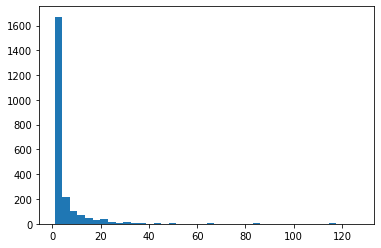

In [33]:
"""
...and the great majority of keywords appear in less than 10 paragraphs.
"""

counts = []
for _, v in keyword_dict.items():
  counts.append(len(v))

plt.hist(counts, bins=40)

In [61]:
"""
Function that returns paragraphs identified by their index and ordered by the contained number of question keywords.
top_paragraphs is what we need to answer the user's question, but return sorted_paragraph_tuples is returned as well for debugging.
"""

def get_context_candidates(sentence, keyword_dict, spacy_model):
  words = simple_tokens([sentence], spacy_model)

  paragraph_occurences = {}
  for w in words[0]:
    if w in keyword_dict:
      for idx in keyword_dict[w]:
        if idx in paragraph_occurences:
          paragraph_occurences[idx] += 1
        else:
          paragraph_occurences[idx] = 1
  sorted_paragraphs_tuples = sorted(paragraph_occurences.items(), key=lambda item: item[1], reverse=True)
  min_hits = sorted_paragraphs_tuples[0][1] - 1          # Only want contexts that contain most hits with question
  top_paragraphs = [p[0] for p in sorted_paragraphs_tuples if p[1] >= min_hits]
  return top_paragraphs, sorted_paragraphs_tuples

In [62]:
top_paragraphs, sorted_paragraphs_tuples = get_context_candidates("What is a card's thrust triangle?", keyword_dict, spacy_model)
print(sorted_paragraphs_tuples)
print(top_paragraphs)

[(18, 3), (23, 3), (29, 3), (554, 3), (107, 3), (190, 3), (509, 3), (528, 2), (670, 2), (201, 2), (220, 2), (267, 2), (371, 2), (17, 2), (530, 2), (96, 2), (133, 2), (182, 2), (194, 2), (195, 2), (203, 2), (713, 2), (206, 2), (729, 2), (218, 2), (221, 2), (238, 2), (256, 2), (261, 2), (372, 2), (393, 2), (397, 2), (399, 2), (400, 2), (401, 2), (444, 2), (514, 1), (7, 1), (14, 1), (19, 1), (21, 1), (22, 1), (24, 1), (533, 1), (534, 1), (537, 1), (544, 1), (549, 1), (555, 1), (561, 1), (53, 1), (565, 1), (62, 1), (77, 1), (591, 1), (82, 1), (599, 1), (605, 1), (95, 1), (615, 1), (106, 1), (108, 1), (618, 1), (110, 1), (619, 1), (622, 1), (628, 1), (629, 1), (651, 1), (652, 1), (144, 1), (656, 1), (163, 1), (688, 1), (697, 1), (186, 1), (705, 1), (708, 1), (722, 1), (736, 1), (737, 1), (244, 1), (245, 1), (762, 1), (767, 1), (775, 1), (266, 1), (782, 1), (276, 1), (280, 1), (282, 1), (283, 1), (284, 1), (285, 1), (286, 1), (287, 1), (288, 1), (290, 1), (293, 1), (296, 1), (297, 1), (299, 

## Putting It All Together
We have several examples below (see test_combos) and see that the whole thing doesn't quite work yet. Some questions yield resonable answers, but most do not, neither for our tuned question-answering model nor for the off-the-shelf SQaAD v1 model.

I think there is much more to explore, which I look forward to continuing. The biggest next step is to train on SQaAD v2 and teach the model to identify a lack of answer.

In [64]:
question = 'What size is the thrust modifier cards in the neptune zone receive if they get a push?'
context_idxs, _ = get_context_candidates(question, keyword_dict, spacy_model)
contexts = [f_headsMerged[i] for i in context_idxs]
answer, score, context = question_all(question1, contexts, qa_untuned_pipe)
print(answer)
print(score)
print(context)

modified per H3c
0.18258115649223328
Solar-Powered Card is one with the solar icon (B2e). If a thruster or thruster support is solar-powered, the thrust is modified per H3c. Solar-powered cards are non-operational in the Neptune J Heliocentric Zone (labeled "NO SOLAR POWER") unless getting a push from a Powersat (-6 thrust). Solar-powered cards cannot be used in the Jupiter zone or beyond when anchoring a Bernal (2A5), unless getting a push from a Powersat. 


In [63]:
test_combos = [
               (question1, target1, qa_untuned_pipe, 'untuned'),
               (question1, target1, qa_tuned_pipe, 'tuned'),
               (question2, target2, qa_untuned_pipe, 'untuned'),
               (question2, target2, qa_tuned_pipe, 'tuned'),
               (question3, target3, qa_untuned_pipe, 'untuned'),
               (question3, target3, qa_tuned_pipe, 'tuned'),
               (question4a, target4, qa_untuned_pipe, 'untuned'),
               (question4a, target4, qa_tuned_pipe, 'tuned'),
               (question4b, target4, qa_untuned_pipe, 'untuned'),
               (question4b, target4, qa_tuned_pipe, 'tuned'),
               (question5, target5, qa_untuned_pipe, 'untuned'),
               (question5, target5, qa_tuned_pipe, 'tuned')
]

prev_question = ''
for question, target, pipeline, label in test_combos:
  context_idxs, _ = get_context_candidates(question, keyword_dict, spacy_model)
  contexts = [f_headsMerged[i] for i in context_idxs]
  answer, score, context = question_all(question, contexts, pipeline)
  if question != prev_question:
    print()
    print(f'{question}  CORRECT ANS: {target}')
    prev_question = question
  print(f'{label} answer: {answer}  --> {score:.2%}')
  print(f'  {context}')


What does the Thrust Triangle color indicate?  CORRECT ANS: fuel grade
untuned answer: movement-modifying supports  --> 48.99%
  i. Wrench Icons indicate movement-modifying supports ( J5). These modifiers apply only if the card is part of the support chain (J1c) for an activated thrust triangle.
tuned answer: movement-modifying supports  --> 65.14%
  i. Wrench Icons indicate movement-modifying supports ( J5). These modifiers apply only if the card is part of the support chain (J1c) for an activated thrust triangle.

What color is the sky?  CORRECT ANS: blue
untuned answer: F4b  --> 88.43%
  d. Fueling & Wet Mass Chit. When first created, a Rocket’s tanks are empty. Indicate this by selecting a Wet Mass Chit of the same color (F4b) as the Spacecraft's thrust triangle and placing it on top of your Dry Mass Chit. If you wish to immediately add Fuel to your Rocket, either by cargo transfer (G1) or site refuel (I5), move the Wet Mass Chit to the right per (F3b)
tuned answer: gray  --> 85.2